# Fastest Trajectory with Monte Carlo Control

In [3]:
import gym
import racetrack
import numpy as np
from matplotlib import pyplot as plt

<Axes: >

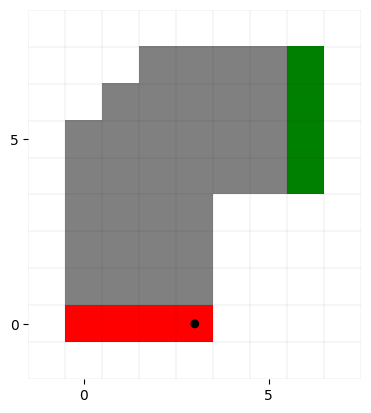

In [4]:
env = gym.make('Racetrack-v0', track='test')

state = env.reset()
env.render()

### Goal 
- You want to go as fast as possible, but not so fast as to run off the track.

### Observation Space
- The car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step.
- [0, 0, 0, 0] -> x=0, y=0, vx=0, vy=0

### Actions
- The actions are increments to the velocity components:
    - Each may be changed by +1, 0 or -1 in each step, for a total of nine (3 x 3) actions.
    - Both velocity components are restricted to be non-negative and less than 5, and they cannot both be zero except at the starting line
    - If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues.
- Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line.
- To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments.

### Reward
- The rewards are -1 for each step until the car crosses the finish line.

### End of episode
- Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary.
    - If it intersects the finish line, the episode ends;
    - if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line.


<Axes: >

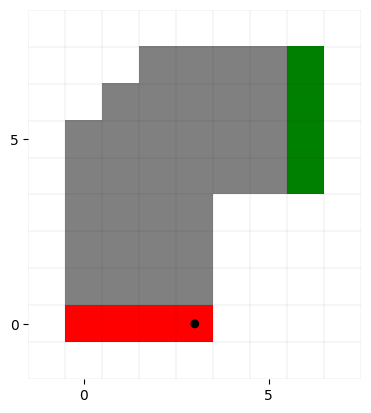

In [5]:
# what is gym? https://gymnasium.farama.org/index.html
env = gym.make('Racetrack-v0', track='test')

state = env.reset()
env.render()

In [6]:
print(f"""

state: {state}
action space: {env.action_space}
action sample: {env.action_space.sample()}
observation space: {env.observation_space}
observation space: {env.observation_space.sample()}

""")



state: [3 0 0 0]
action space: MultiDiscrete([3 3])
action sample: [0 1]
observation space: MultiDiscrete([7 8 5 5])
observation space: [5 0 4 3]




### Sample Episode

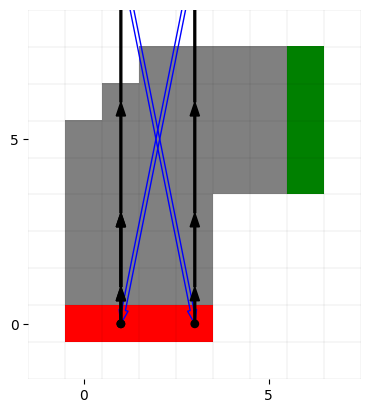

In [8]:
env = gym.make('Racetrack-v0', track='test',noisy=False)
state = env.reset()
ax = env.render()

for i in range(10):
    action = np.array([1,2])
    env.step(action)
    env.render()

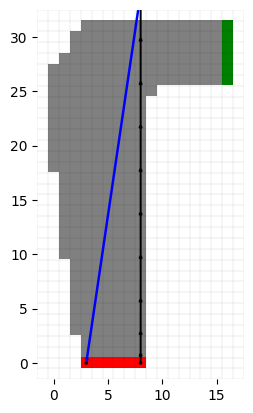

In [9]:
env = gym.make('Racetrack-v0', track='A',noisy=False)
state = env.reset()
ax = env.render()

for i in range(10):
    action = np.array([1,2])
    state, reward, done, info = env.step(action)
    env.render()

## Setup RL variables for Monte Carlo

Let's build our Q-value table from the state/action spaces

In [10]:
num_states = np.prod(env.observation_space.nvec)
num_actions = np.prod(env.action_space.nvec)

print(f"""

num_states: {num_states}
num_actions: {num_actions}

""")



num_states: 13600
num_actions: 9




In [11]:
# init Q uniformly
q = np.ones([num_states, num_actions])
q.shape

(13600, 9)

In [12]:
# init random uniform policy
policy = q / num_actions
policy

array([[0.11111111, 0.11111111, 0.11111111, ..., 0.11111111, 0.11111111,
        0.11111111],
       [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111, 0.11111111,
        0.11111111],
       [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111, 0.11111111,
        0.11111111],
       ...,
       [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111, 0.11111111,
        0.11111111],
       [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111, 0.11111111,
        0.11111111],
       [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111, 0.11111111,
        0.11111111]])

In [13]:
def sample_episode(env, policy, render=False):
    """ Follow policy through an episode and return arrays of visited actions, states and returns """
    
    possible_actions = np.arange(int(np.prod(env.action_space.nvec)))
    state_idxs = []
    action_idxs = []
    rewards = []

    done = False
    state = env.reset()
    if render:
        env.render()

    while not done:
        # convert in flatten idx, i.e. [0, 0, 0, 0] -> 0, [0, 0, 0, 1] -> 1 etc.
        state_idx = np.ravel_multi_index(state, env.observation_space.nvec)
        state_idxs.append(state_idx)

        # Sample action from the policy
        action_idx = np.random.choice(possible_actions, p=policy[state_idx])
        action = np.array(np.unravel_index(action_idx, env.action_space.nvec))
        action_idxs.append(action_idx)

        # Step the environment forward and take the sampled action
        state, reward, done, info = env.step(action)
        rewards.append(reward)

        if render:
            env.render()

    return state_idxs, action_idxs, rewards

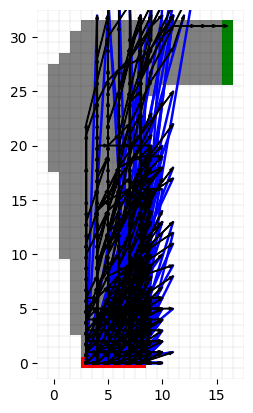

In [14]:
states_idxs, action_idxs, rewards = sample_episode(env, policy, render=True)

## Monte Carlo Policy Learning

![monte_carlo](img/monte_carlo.png)

In [15]:
def monte_carlo_control_eps_soft(env, num_episodes, eps=0.10, alpha=0.05):
    
    # Optimistic (i.e. encouraging exploration) initialization of state-action values
    q = np.ones([num_states, num_actions])
    
    # Initialize policy to eps-soft greedy wrt to random q
    policy = q / num_actions
    
    for episode in range(int(num_episodes)):
        # Sample an episode and collect first-visit states, actions & returns
        state_idxs, action_idxs, rewards = sample_episode(env, policy)

        # compute long term returns in the horizon
        returns = np.cumsum(rewards[::-1])[::-1]
        
        # Update the state-action values with first-visit returns
        for state_idx, action_idx, R in zip(state_idxs, action_idxs, returns):
            q[state_idx, action_idx] += alpha * (R - q[state_idx, action_idx])
    
        # Update policy to be eps-soft greedy wrt to updated q values
        greedy_action_idxs = np.argmax(q[state_idxs, :], axis=1)
        policy[state_idxs, :] = eps / num_actions
        policy[state_idxs, greedy_action_idxs] = 1 - eps + eps / num_actions
    
        if episode % 5000 == 0:
            print(f"Episode {episode}/{num_episodes}: #updates={len(state_idxs)} return={returns[0]}")
    
    # Return deterministic greedy policy wrt q values
    greedy_action_ridxs = np.argmax(q, axis=1)
    policy[:, :] = 0
    policy[np.arange(num_states), greedy_action_ridxs] = 1
    return q, policy

In [16]:
%%time
q, policy = monte_carlo_control_eps_soft(env, 5e4, eps=0.1, alpha=0.1)

Episode 0/50000.0: #updates=989 return=-989.0
Episode 5000/50000.0: #updates=67 return=-67.0
Episode 10000/50000.0: #updates=26 return=-26.0
Episode 15000/50000.0: #updates=21 return=-21.0
Episode 20000/50000.0: #updates=35 return=-35.0
Episode 25000/50000.0: #updates=35 return=-35.0
Episode 30000/50000.0: #updates=25 return=-25.0
Episode 35000/50000.0: #updates=34 return=-34.0
Episode 40000/50000.0: #updates=16 return=-16.0
Episode 45000/50000.0: #updates=42 return=-42.0
CPU times: user 2min 15s, sys: 260 ms, total: 2min 15s
Wall time: 2min 17s


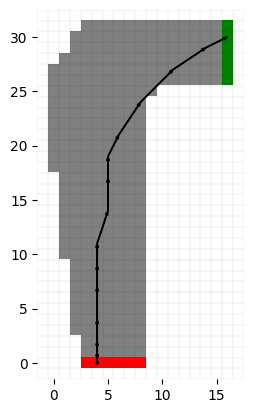

In [17]:
_ = sample_episode(env, policy, render=True)

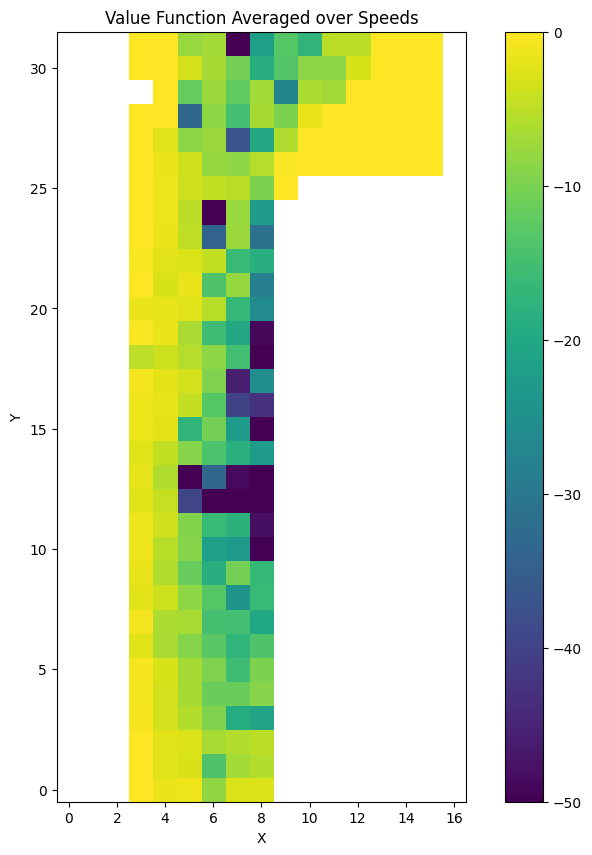

In [18]:
v = np.max(q, axis=1).reshape(env.observation_space.nvec)
v_pos = np.mean(v, axis=(2, 3))        

unvisited_filter = np.where(v_pos == 1.0)
v_pos[unvisited_filter] = np.nan

v_pos = np.clip(v_pos, -50, 0)

plt.figure(figsize=(10,10))
plt.title("Value Function Averaged over Speeds")
plt.xlabel("X")
plt.ylabel("Y")
plt.imshow(v_pos.T, origin='lower')
plt.colorbar()

Text(0, 0.5, 'Y')

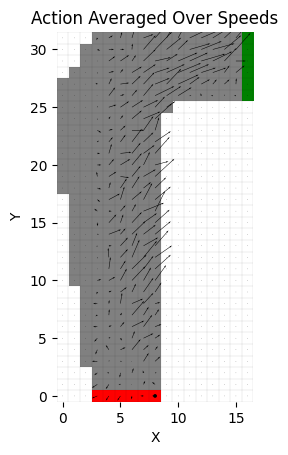

In [19]:
a_star_ridxs = np.argmax(policy, axis=1).reshape(env.observation_space.nvec)
a_stars = np.array(np.unravel_index(a_star_ridxs, env.action_space.nvec)) - env.max_accel
a_stars_mean = np.mean(a_stars, axis=(-1, -2))
a_stars_norm = (a_stars_mean.T - np.mean(a_stars_mean, axis=(1, 2))).T
a_stars_norm[:, unvisited_filter[0], unvisited_filter[1]] = 0

env.reset()
axis = env.render()
xs, ys = np.arange(env.observation_space.nvec[0]), np.arange(env.observation_space.nvec[1])
a_star_x, a_star_y = a_stars_norm[0], a_stars_norm[1]
axis.quiver(xs, ys, a_star_x.T, a_star_y.T)

plt.title("Action Averaged Over Speeds")
plt.xlabel("X")
plt.ylabel("Y")